In [1]:
#%env CUDA_VISIBLE_DEVICES=0,1
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import sys
sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Microtubule")
data_dir = root_dir / "Data"
model_dir = root_dir / "Logs"
saved_model_dir = root_dir / "SavedModel"
log_file = model_dir / "current_training.log"

# Import the configuration associated with this dataset and network.
params = maskflow.load_parameters(root_dir / "parameters.yml")

Using TensorFlow backend.


# Load Dataset

In [2]:
# Split dataset
fnames = list((data_dir / "Image").glob("*.tif"))
#fnames = np.random.choice(fnames, 50)
train_fnames, validation_fnames = train_test_split(fnames, test_size=0.15, random_state=10)

# Build dataset
dataset_train = maskflow.MaskflowDataset()
dataset_train.set_dataset(train_fnames, params["CLASS_NAMES"])

dataset_val = maskflow.MaskflowDataset()
dataset_val.set_dataset(validation_fnames, params["CLASS_NAMES"])

print(f"train_fnames : {len(train_fnames)} | validation_fnames : {len(validation_fnames)}")

train_fnames : 1093 | validation_fnames : 193


{'id': 798, 'source': '', 'path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Image/field_17_AUGMENTED_9.tif'), 'mask_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Mask/field_17_AUGMENTED_9.tif'), 'class_ids_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Class/field_17_AUGMENTED_9.csv')}


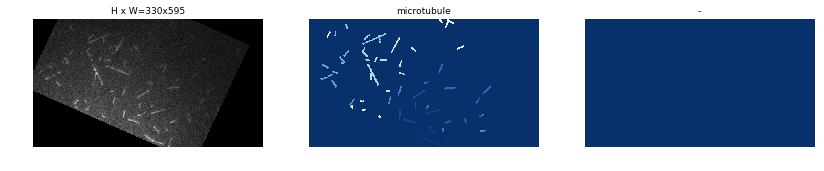

{'id': 129, 'source': '', 'path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Image/image_snr_3.7_n-mts_136.66666666666669_id_2.tif'), 'mask_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Mask/image_snr_3.7_n-mts_136.66666666666669_id_2.tif'), 'class_ids_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Class/image_snr_3.7_n-mts_136.66666666666669_id_2.csv')}


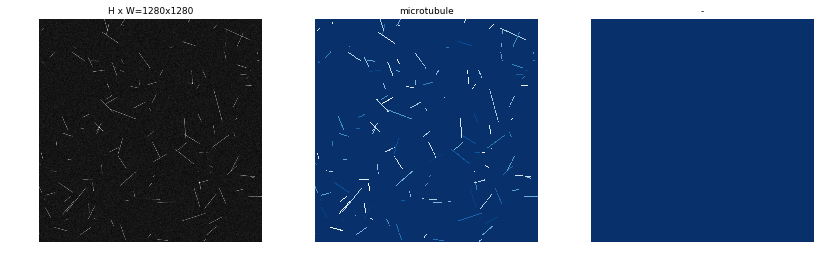

In [3]:
dataset_train.random_display(n=2, n_class=2)

# Training

In [4]:
# Configure the model and the training
config = maskflow.get_config(params)

config.IMAGES_PER_GPU = 1
config.GPU_COUNT = 1
config.STEPS_PER_EPOCH = dataset_train.num_images // config.IMAGES_PER_GPU
config.VALIDATION_STEPS = dataset_val.num_images // config.IMAGES_PER_GPU
config.LEARNING_RATE = 0.001

config.update()
#config.display()

In [5]:
# Set the training name to resume a training or to None to start training from scratch.
training_name = "run_1"
#training_name = None

# When training from scratch you can init the network with "coco" or "imagenet"
init_with = "coco"

# Load model
model = maskflow.load_model(model_dir, config, training_name=training_name, mode="training", init_with=init_with)
model.load_weights()

2018-07-08 13:06:52:Maskflow:INFO:Set log_dir to /home/hadim/.data/Neural_Network/Maskflow/Microtubule/Logs/run_1
2018-07-08 13:06:52:Maskflow:INFO:Found weights from epoch 28
2018-07-08 13:06:52:Maskflow:INFO:Start building Keras model.
2018-07-08 13:06:57:Maskflow:INFO:Keras model built.
2018-07-08 13:06:57:Maskflow:INFO:Load weights from previous training /home/hadim/.data/Neural_Network/Maskflow/Microtubule/Logs/run_1/mask_rcnn_microtubule_detector_0028.h5.
2018-07-08 13:07:02:Maskflow:INFO:Done loading weights.


In [6]:
# Callback to execute during training
callbacks = []
callbacks.append(maskflow.FileLogger(log_file))
callbacks.append(maskflow.TelegramLogger())

In [ ]:
model.train(dataset_train, dataset_val, epochs=50, layers='heads', custom_callbacks=callbacks, learning_rate=config.LEARNING_RATE)

2018-07-08 13:07:44:Maskflow:INFO:Starting at epoch 29. Learning Rate=0.001
2018-07-08 13:07:44:Maskflow:INFO:Checkpoint Path: /home/hadim/.data/Neural_Network/Maskflow/Microtubule/Logs/run_1/mask_rcnn_microtubule_detector_{epoch:04d}.h5
2018-07-08 13:07:44:Maskflow:INFO:Selecting layers to train
2018-07-08 13:07:44:Maskflow:INFO:	fpn_c5p5             (Conv2D)
2018-07-08 13:07:44:Maskflow:INFO:	fpn_c4p4             (Conv2D)
2018-07-08 13:07:44:Maskflow:INFO:	fpn_c3p3             (Conv2D)
2018-07-08 13:07:44:Maskflow:INFO:	fpn_c2p2             (Conv2D)
2018-07-08 13:07:44:Maskflow:INFO:	fpn_p5               (Conv2D)
2018-07-08 13:07:44:Maskflow:INFO:	fpn_p2               (Conv2D)
2018-07-08 13:07:44:Maskflow:INFO:	fpn_p3               (Conv2D)
2018-07-08 13:07:44:Maskflow:INFO:	fpn_p4               (Conv2D)
2018-07-08 13:07:44:Maskflow:INFO:In model: rpn_model
2018-07-08 13:07:44:Maskflow:INFO:Selecting layers to train
2018-07-08 13:07:44:Maskflow:INFO:		rpn_conv_shared      (Conv2D)
20

In [ ]:
# Finetune layers from ResNet stage 4 and up
model.train(dataset_train, dataset_val, epochs=100, layers='4+', custom_callbacks=callbacks, learning_rate=config.LEARNING_RATE / 10)

In [ ]:
# Fine tune all layers
model.train(dataset_train, dataset_val, epochs=10, layers='all', custom_callbacks=callbacks, learning_rate=config.LEARNING_RATE / 100)

# Detection

In [8]:
training_name = "run_1"

config = maskflow.get_config(params)
config.IMAGES_PER_GPU = 1
config.GPU_COUNT = 1
config.update()

model = maskflow.load_model(model_dir, config, training_name=training_name, mode="inference")
model.load_weights()

2018-07-04 14:50:50:Maskflow:INFO:Set log_dir to /home/hadim/.data/Neural_Network/Maskflow/Microtubule/Logs/current_training
2018-07-04 14:50:50:Maskflow:INFO:Set log_dir to /home/hadim/.data/Neural_Network/Maskflow/Microtubule/Logs/current_training
2018-07-04 14:50:50:Maskflow:INFO:Found weights from epoch 104
2018-07-04 14:50:50:Maskflow:INFO:Found weights from epoch 104
2018-07-04 14:50:50:Maskflow:INFO:Start building Keras model.
2018-07-04 14:50:50:Maskflow:INFO:Start building Keras model.
2018-07-04 14:50:53:Maskflow:INFO:Keras model built.
2018-07-04 14:50:53:Maskflow:INFO:Keras model built.
2018-07-04 14:50:53:Maskflow:INFO:Load weights from previous training /home/hadim/.data/Neural_Network/Maskflow/Microtubule/Logs/current_training/mask_rcnn_microtubule_detector_0104.h5.
2018-07-04 14:50:53:Maskflow:INFO:Load weights from previous training /home/hadim/.data/Neural_Network/Maskflow/Microtubule/Logs/current_training/mask_rcnn_microtubule_detector_0104.h5.
2018-07-04 14:50:55:Ma

## Load one image

{'id': 15, 'source': '', 'path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Image/image_snr_1.9_n-mts_60_id_0.tif'), 'mask_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Mask/image_snr_1.9_n-mts_60_id_0.tif'), 'class_ids_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Class/image_snr_1.9_n-mts_60_id_0.csv')}


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


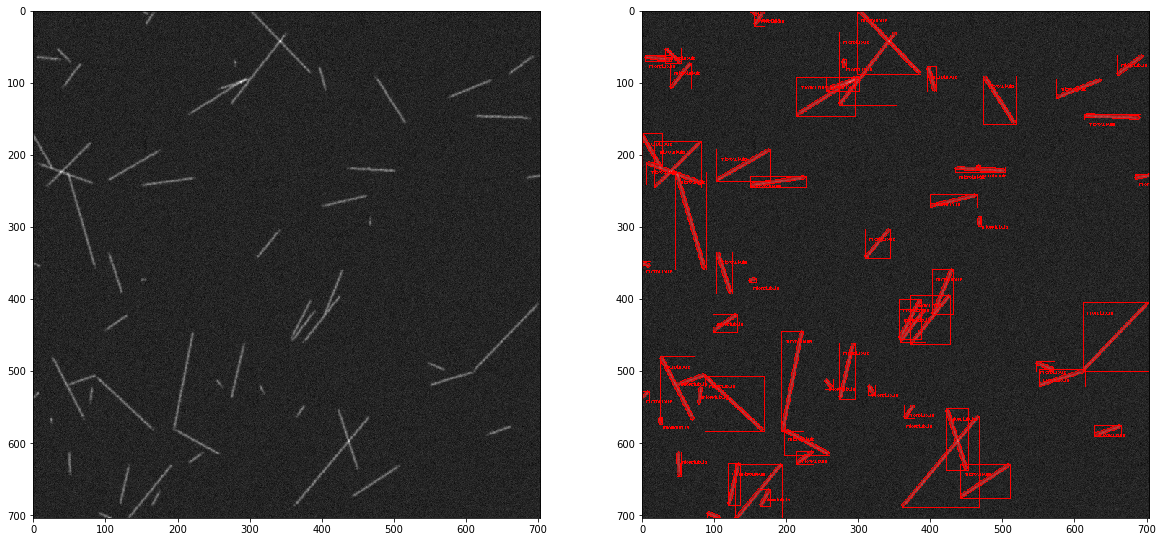

In [17]:
# Load a random image
image_id = np.random.choice(dataset_val.image_ids)
#image_id = 5

print(dataset_val.image_info[image_id])
image, objects = dataset_val.load(image_id)

image_objects = maskflow.draw_objects(image, objects, config.CLASS_NAMES, colors=None, resize_ratio=1,
                                      draw_boxes=True, draw_masks=True, draw_contours=True, draw_score=True)
maskflow.show_images([image, image_objects], size=10, use_widget=False, t=0)

## Detect objects

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


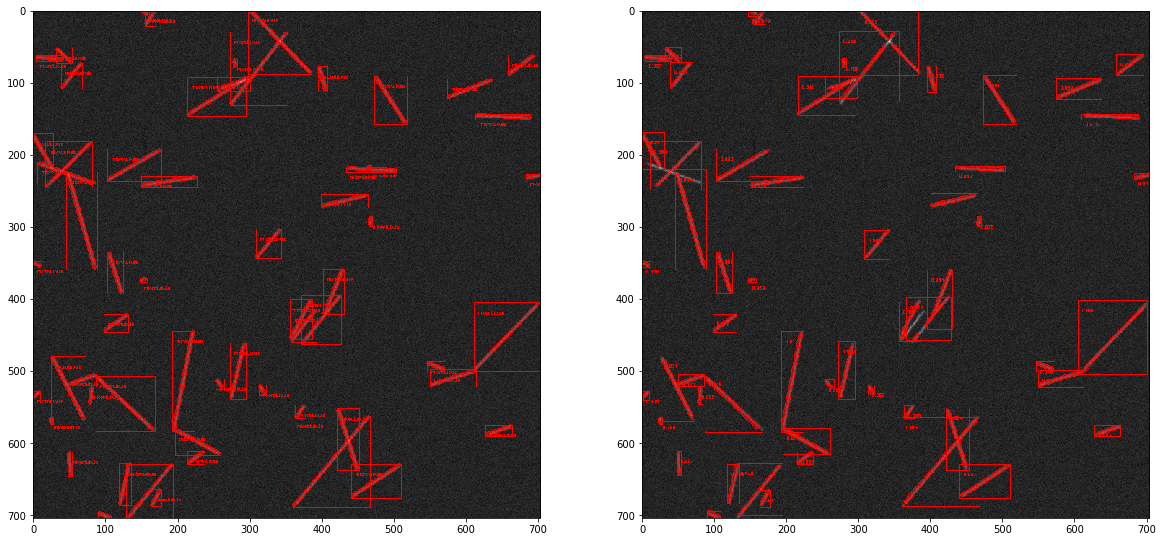

In [18]:
results = model.predict(image, progress=True)

images_results = maskflow.draw_objects(image, results, config.CLASS_NAMES, colors=None, resize_ratio=1,
                                       draw_boxes=True, draw_masks=True, draw_contours=True, draw_score=True)
maskflow.show_images([image_objects, images_results], size=10, use_widget=False, t=0)

# Export trained model to ZIP

In [17]:
maskflow.export_to_zip(model, training_name, saved_model_dir)

INFO:tensorflow:Froze 384 variables.


INFO:tensorflow:Froze 384 variables.


Converted 384 variables to const ops.
